In [1]:
# Calling libraries:
from __future__ import division
%matplotlib inline
import numpy as np, time, matplotlib.pyplot as plt, numpy.random as npr, pystan as ps, pickle, pandas
from pylab import plot, show, legend
from time import time
from scipy.stats import *
from tqdm import trange

In [2]:
sm = ps.StanModel(file="dcc_garch.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a71eb389c5b594fa2df29531bd697d94 NOW.


In [3]:
Y = pandas.read_csv("la_pm_log_positive.csv").values
T, dim = np.shape(Y)

In [4]:
sigma1_0 = 1
sigma2_0 = 1
nu = 4

### Divide-and-conquer:

In [5]:
K = 10
tstarts = np.arange(K).astype(int)
tends = 1 + tstarts
tstarts *= int(T/K)
tends *= int(T/K)

In [ ]:
n_chains = 10
for k in range(K) :
    start = time()
    tstart, tend = tstarts[k], tends[k]
    data = dict(T=tend-tstart, dim=dim, nu=nu, Y=Y[tstart:tend], sigma1_0=sigma1_0, sigma2_0=sigma2_0, power=K)
    fit = sm.sampling(data=data, thin=1, n_jobs=min(10,n_chains), chains=n_chains, init="random", iter=1_000)
    file = open("/xtmp/DC-BATS_data/real_data/dcc_garch_chunk"+str(k+1)+"_mcmc.pkl", "wb")
    pickle.dump(fit.extract(), file)
    file.close()
    print(round((time()-start)/60,2), "minutes to run")

2.3 minutes to run
2.65 minutes to run
1.71 minutes to run
3.84 minutes to run
3.38 minutes to run


11.7 minutes to run
2.27 minutes to run


4.29 minutes to run
4.17 minutes to run
1.59 minutes to run


### MCMC on full data:

In [10]:
start = time()
data = dict(T=T, dim=dim, nu=nu, Y=Y, sigma1_0=sigma1_0, sigma2_0=sigma2_0, power=1)
fit = sm.sampling(data=data, thin=1, n_jobs=min(10,n_chains), chains=n_chains, init="random", iter=1_000)
file = open("/xtmp/DC-BATS_data/real_data/dcc_garch_fulldata_mcmc.pkl", "wb")
pickle.dump(fit.extract(), file)
file.close()
print(round((time()-start)/60,2), "minutes to run")

23.82 minutes to run


### Compare:

In [11]:
params = ['a1', 'a2', 'b1', 'b2', 'r', 'w1', 'w2', 'mu1', 'mu2']
ci_full = np.zeros((2,len(params)))
ci_dc = np.zeros((2,len(params)))

for k in range(K) :
    file = open("/xtmp/DC-BATS_data/real_data/dcc_garch_chunk"+str(k+1)+"_mcmc.pkl", "rb")
    trace = pickle.load(file)
    for (i, param) in enumerate(params) :
        ci_dc[:,i] += np.percentile(trace[param], q=[2.5,97.5])/K
    file.close()

file = open("/xtmp/DC-BATS_data/real_data/dcc_garch_fulldata_mcmc.pkl", "rb")
trace = pickle.load(file)
for (i, param) in enumerate(params) :
    ci_full[:,i] = np.percentile(trace[param], q=[2.5,97.5])
file.close()

In [28]:
ci_dc

array([[5.11703299e-01, 6.50176340e-01, 6.20423826e-02, 8.59306659e-05,
        2.57459930e-01, 1.21611575e-01, 2.00871265e-01, 3.11904062e+00,
        1.94973925e+00],
       [5.85367399e-01, 7.30133586e-01, 1.32131039e-01, 1.09041229e-02,
        2.78448540e-01, 1.42075581e-01, 2.24454252e-01, 3.14439461e+00,
        1.97900590e+00]])

In [29]:
ci_full

array([[5.32926835e-01, 8.76283419e-01, 1.20831701e-01, 6.00019231e-05,
        2.32319226e-01, 9.06966829e-02, 1.22579026e-01, 3.24929022e+00,
        2.09534453e+00],
       [6.19223816e-01, 9.76039186e-01, 2.11648382e-01, 7.45822725e-03,
        2.53858338e-01, 1.10146544e-01, 1.40392496e-01, 3.27664423e+00,
        2.12381878e+00]])

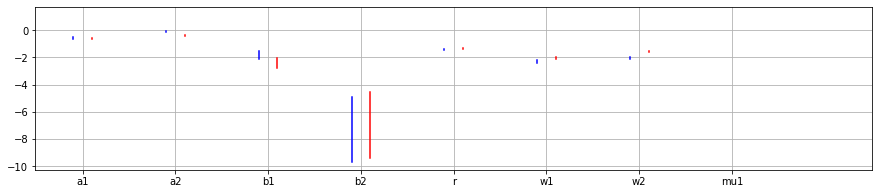

In [22]:
plt.rcParams['figure.figsize'] = (15, 3)
for (i, param) in enumerate(params) :
    plt.plot([i+0.9,i+0.9], np.log(ci_full[:,i]), "b-")
    plt.plot([i+1.1,i+1.1], np.log(ci_dc[:,i]), "r-")
plt.grid(True)
plt.xticks(ticks=np.arange(1,len(params)), labels=params);